In [1]:
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Download the Excel file manually from the provided URL and save it to your local directory
# Then specify the file path to the downloaded Excel file
file_path = "Date_Fruit_Datasets.xlsx"

# Read the dataset
dataframe = pd.read_excel(file_path)
#dataframe.head()

In [3]:
dataframe.drop(["PERIMETER","MAJOR_AXIS","MINOR_AXIS","CONVEX_AREA","MeanRR","ALLdaub4RR","EntropyRG"], axis=1, inplace=True)

In [4]:
dataframe.drop(["MeanRG","StdDevRR","StdDevRG","ALLdaub4RB","EntropyRB","SkewRG","SkewRR","KurtosisRR","KurtosisRG"], axis=1, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split

def train_test_split_data(dataframe, target, test_size, random_state):
    # Splitting into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop([target], axis=1),
        dataframe[target],
        test_size=test_size,
        random_state=random_state,
        stratify=dataframe[target]
    )
    
    # Further split the train set into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=test_size,  # Use the same test_size for validation set
        random_state=random_state,
        stratify=y_train  # Stratify based on the train set
    )

    return x_train, x_val, x_test, y_train, y_val, y_test


x_train, x_val, x_test, y_train, y_val, y_test = train_test_split_data(dataframe, 'Class', test_size=0.2, random_state=42)


def get_numerical_and_categorical_columns(dataframe):
    
    numerical_cols = []
    categorical_cols = []
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            numerical_cols.append(column)
        else:
            categorical_cols.append(column)
            
    return numerical_cols, categorical_cols


numerical_cols, categorical_cols=get_numerical_and_categorical_columns(dataframe)


def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train


ratio_of_outliers,x_train,y_train= Winsorization_Method(numerical_cols, x_train, y_train, a=0.2, b=99.2)


robust_scaler = RobustScaler()
x_train_scaled = robust_scaler.fit_transform(x_train)
x_val_scaled = robust_scaler.transform(x_val)
x_test_scaled = robust_scaler.transform(x_test)   

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

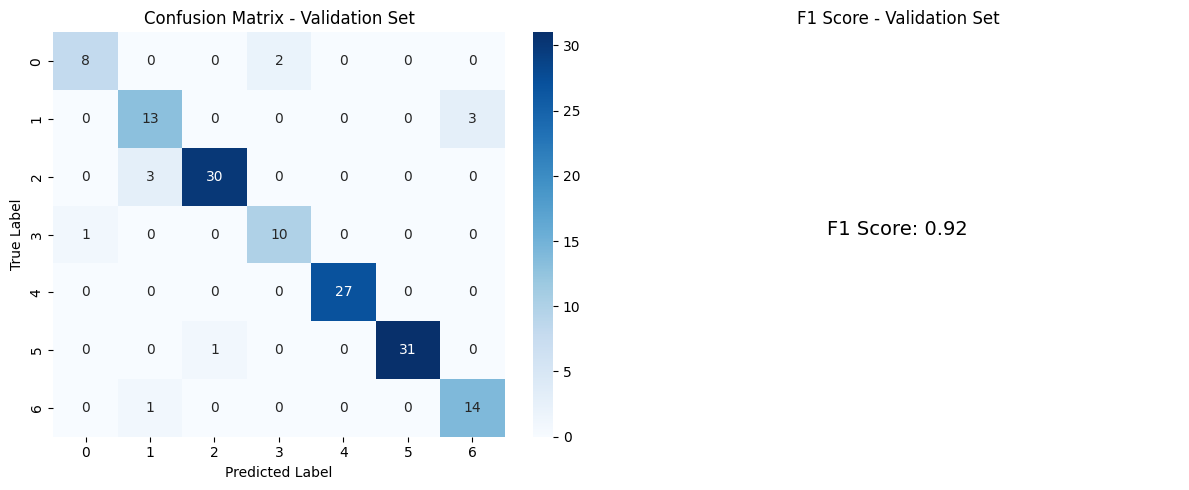

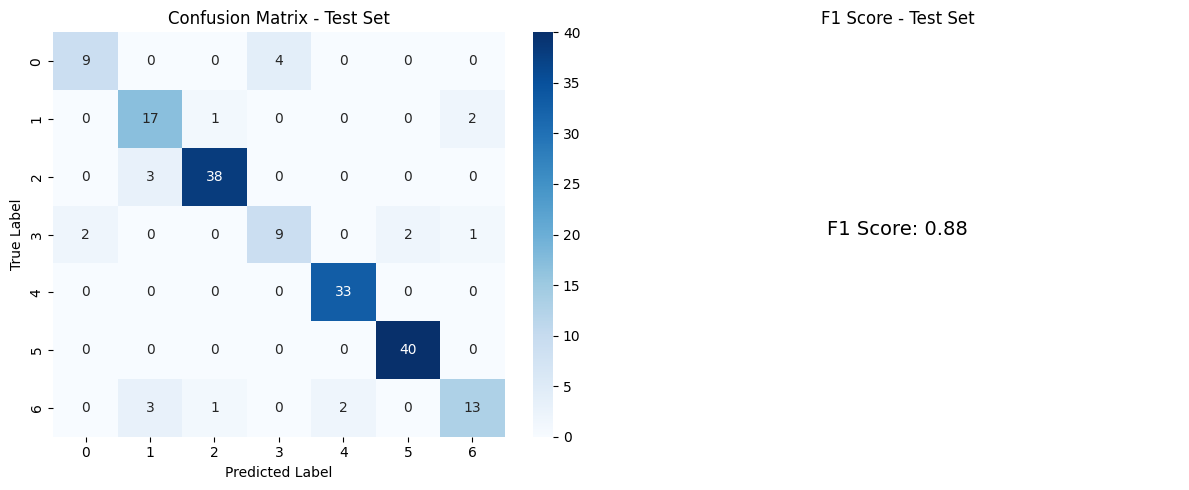

In [6]:
def modelling_RandomForestClassifier(x_train, x_val, x_test, y_train, y_val, y_test):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    # Initialize Logistic Regression model
    model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced"
                             , max_features=None, max_samples=0.5, oob_score=True)
    # Train the Logistic Regression model
    model.fit(x_train, y_train)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage:
modelling_RandomForestClassifier(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded)


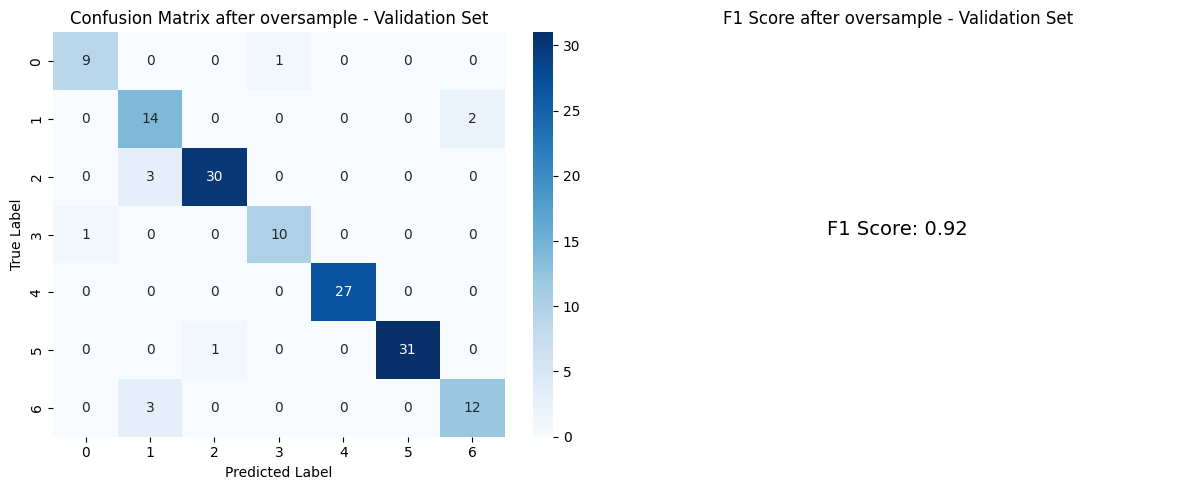

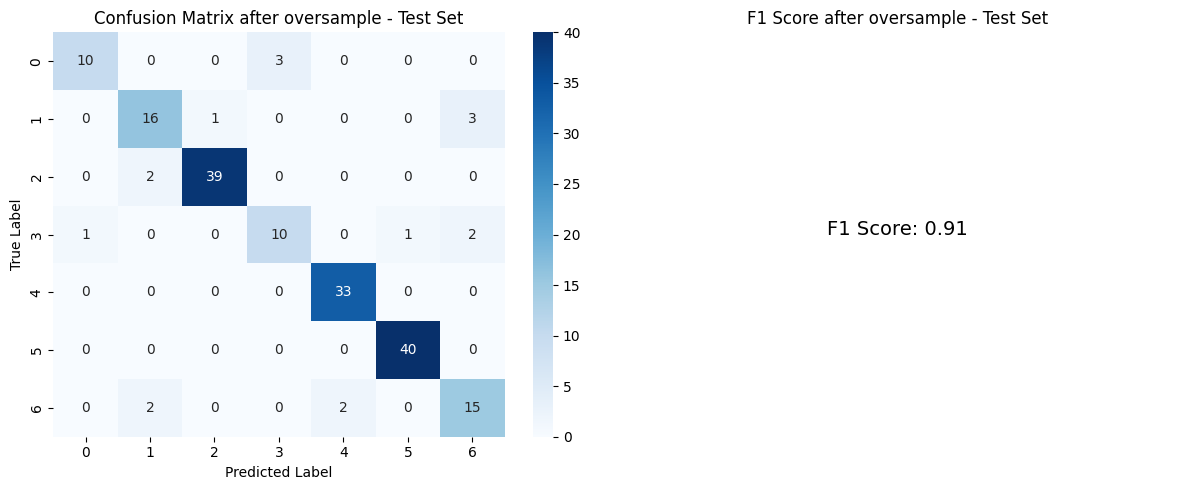

In [17]:
from imblearn.over_sampling import SMOTE

def modelling_RandomForestClassifier(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    # Initialize Random Forest model
    model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced"
                             , max_features=None, max_samples=0.5, oob_score=True)
    # Train the Random Forest model
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix after oversample - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score after oversample - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE:
modelling_RandomForestClassifier(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True)


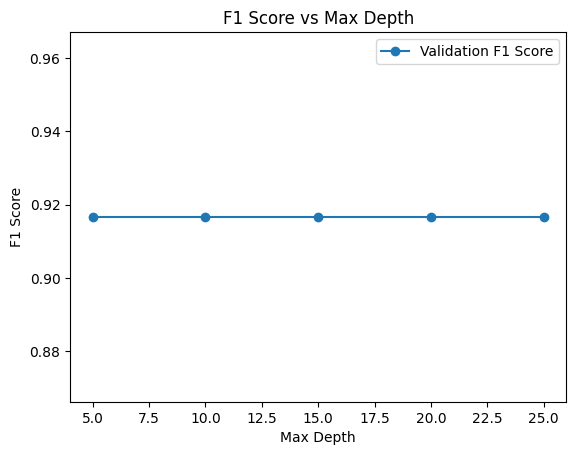

In [8]:
from sklearn.metrics import f1_score

def tune_max_depth(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, max_depths=[5, 10, 15, 20]):
    # Create lists to store F1 scores for validation and test sets
    f1_scores_val = []
    f1_scores_test = []

    for depth in max_depths:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=0)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Initialize Random Forest model with the current max_depth
        model = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=0, criterion="entropy", class_weight="balanced"
                                 , max_features=None, max_samples=0.5, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        f1_scores_val.append(f1_score_val)

    # Plot F1 scores for validation set
    plt.plot(max_depths, f1_scores_val, marker='o', label='Validation F1 Score')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Max Depth')
    plt.legend()
    plt.show()

# Example usage with SMOTE and different max_depth values:
tune_max_depth(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, max_depths=[5, 10, 15, 20, 25])


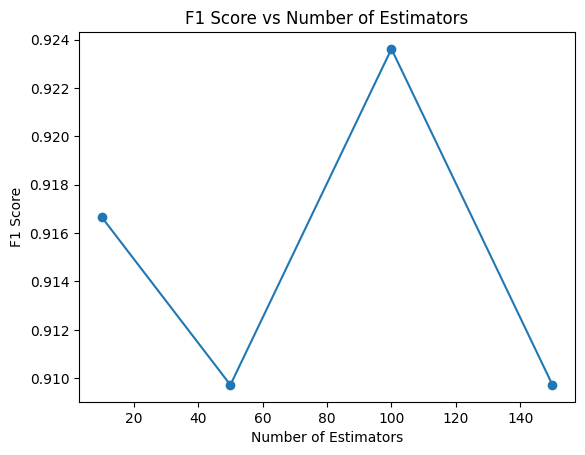

In [9]:
def tune_n_estimators(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, n_estimators_list=[10, 50, 100]):
    # Create lists to store F1 scores for validation and test sets
    f1_scores_val = []
    f1_scores_test = []

    for n_estimators in n_estimators_list:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=0)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Initialize Random Forest model with the current n_estimators
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced"
                                 , max_features=None, max_samples=0.5, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        f1_scores_val.append((n_estimators, f1_score_val))

    # Plot F1 scores for validation set
    n_estimators_values = [n_estimators for n_estimators, _ in f1_scores_val]
    f1_scores = [f1_score for _, f1_score in f1_scores_val]
    plt.plot(n_estimators_values, f1_scores, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Number of Estimators')
    plt.show()

# Example usage with SMOTE and different n_estimators values:
tune_n_estimators(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, n_estimators_list=[10, 50, 100, 150])


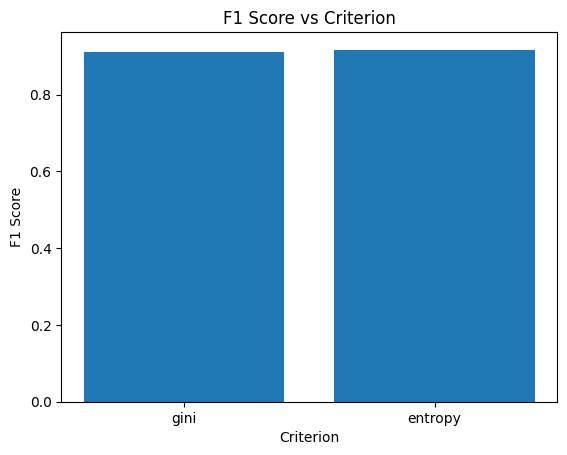

In [10]:
def tune_criterion(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, criterion_list=['gini', 'entropy']):
    # Create lists to store F1 scores for validation and test sets
    f1_scores_val = []

    for criterion in criterion_list:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=0)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Initialize Random Forest model with the current criterion
        model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion=criterion, class_weight="balanced"
                                 , max_features=None, max_samples=0.5, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        f1_scores_val.append((criterion, f1_score_val))

    # Plot F1 scores for validation set
    criterion_values = [criterion for criterion, _ in f1_scores_val]
    f1_scores = [f1_score for _, f1_score in f1_scores_val]
    plt.bar(criterion_values, f1_scores)
    plt.xlabel('Criterion')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Criterion')
    plt.show()

# Example usage with SMOTE and different criterion values:
tune_criterion(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, criterion_list=['gini', 'entropy'])


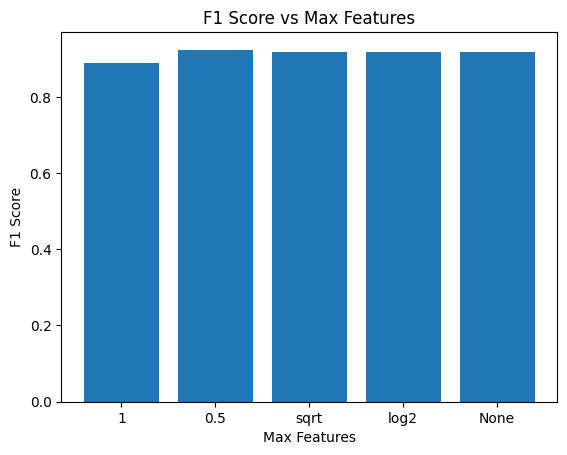

In [11]:
def tune_max_features(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, max_features_list=[1, 0.5, 'sqrt', 'log2', None]):
    # Create lists to store F1 scores for validation and test sets
    f1_scores_val = []

    for max_features in max_features_list:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=0)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Initialize Random Forest model with the current max_features
        model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced",
                                       max_features=max_features, max_samples=0.5, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        f1_scores_val.append((max_features, f1_score_val))

    # Plot F1 scores for validation set
    max_features_values = [str(max_features) for max_features in max_features_list]  # Convert max_features to strings for plotting
    f1_scores = [f1_score for _, f1_score in f1_scores_val]
    plt.bar(max_features_values, f1_scores)
    plt.xlabel('Max Features')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Max Features')
    plt.show()

# Example usage with SMOTE and different max_features values:
tune_max_features(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, max_features_list=[1, 0.5, 'sqrt', 'log2', None])

In [12]:
from sklearn.metrics import f1_score
import math

def tune_max_features(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, max_features_list=[1, 0.5, 'sqrt', 'log2', None]):
    # Calculate the number of features in the dataset
    num_features = x_train.shape[1]

    # Create a dictionary to store F1 scores for different max_features
    f1_scores = {}

    for max_features in max_features_list:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=0)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        if max_features == 'sqrt':
            max_features = int(math.sqrt(num_features))
        elif max_features == 'log2':
            max_features = int(math.log2(num_features))

        # Initialize Random Forest model with the current max_features
        model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced",
                                       max_features=max_features, max_samples=0.5, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        
        # Store F1 score in the dictionary
        f1_scores[max_features] = f1_score_val

    return f1_scores

# Example usage with SMOTE and different max_features values:
max_features_f1_scores = tune_max_features(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, max_features_list=[1, 0.5, 'sqrt', 'log2', None])
print("F1 Scores for different max_features values:", max_features_f1_scores)


F1 Scores for different max_features values: {1: 0.8888888888888888, 0.5: 0.9236111111111112, 4: 0.9166666666666666, None: 0.9166666666666666}


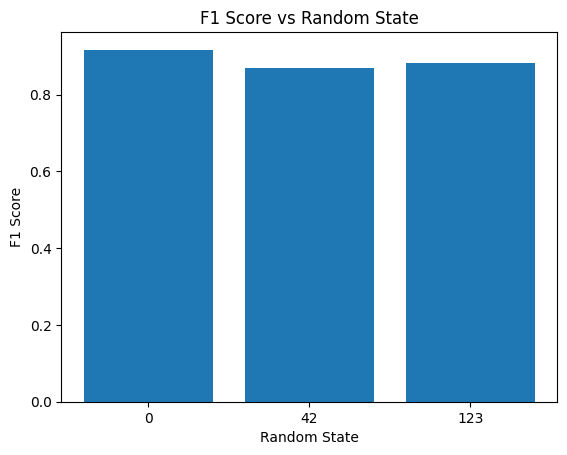

In [13]:
def tune_random_state(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, random_state_list=[0]):
    # Create lists to store F1 scores for validation and test sets
    f1_scores_val = []

    for random_state in random_state_list:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=random_state)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Initialize Random Forest model with the current random_state
        model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=random_state, criterion="entropy", class_weight="balanced",
                                       max_samples=0.5, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        f1_scores_val.append((random_state, f1_score_val))

    # Plot F1 scores for validation set
    random_state_values = [str(random_state) for random_state in random_state_list]  # Convert random_state to strings for plotting
    f1_scores = [f1_score for _, f1_score in f1_scores_val]
    plt.bar(random_state_values, f1_scores)
    plt.xlabel('Random State')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Random State')
    plt.show()

# Example usage with SMOTE and different random_state values:
tune_random_state(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, random_state_list=[0, 42, 123])


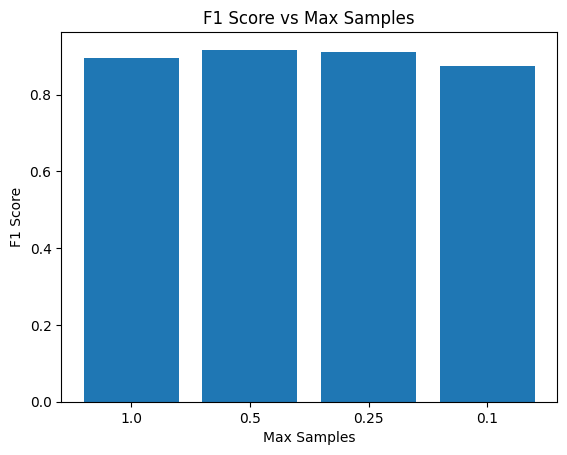

In [14]:
def tune_max_samples(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, max_samples_list=[1.0, 0.5, 0.25, 0.1]):
    # Create lists to store F1 scores for validation and test sets
    f1_scores_val = []

    for max_samples in max_samples_list:
        # Create an empty dictionary to store the confusion matrices and F1 scores
        evaluation_results = {}

        if oversample:
            # Perform oversampling on the training data using SMOTE
            smote = SMOTE(random_state=0)
            x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Initialize Random Forest model with the current max_samples
        model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced",
                                       max_samples=max_samples, oob_score=True)
        # Train the Random Forest model
        model.fit(x_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)

        # Calculate F1 score for validation set
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')
        f1_scores_val.append((max_samples, f1_score_val))

    # Plot F1 scores for validation set
    max_samples_values = [str(max_samples) for max_samples in max_samples_list]  # Convert max_samples to strings for plotting
    f1_scores = [f1_score for _, f1_score in f1_scores_val]
    plt.bar(max_samples_values, f1_scores)
    plt.xlabel('Max Samples')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Max Samples')
    plt.show()

# Example usage with SMOTE and different max_samples values:
tune_max_samples(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, max_samples_list=[1.0, 0.5, 0.25, 0.1])


Cross-validation F1 Score: 0.90 +/- 0.05


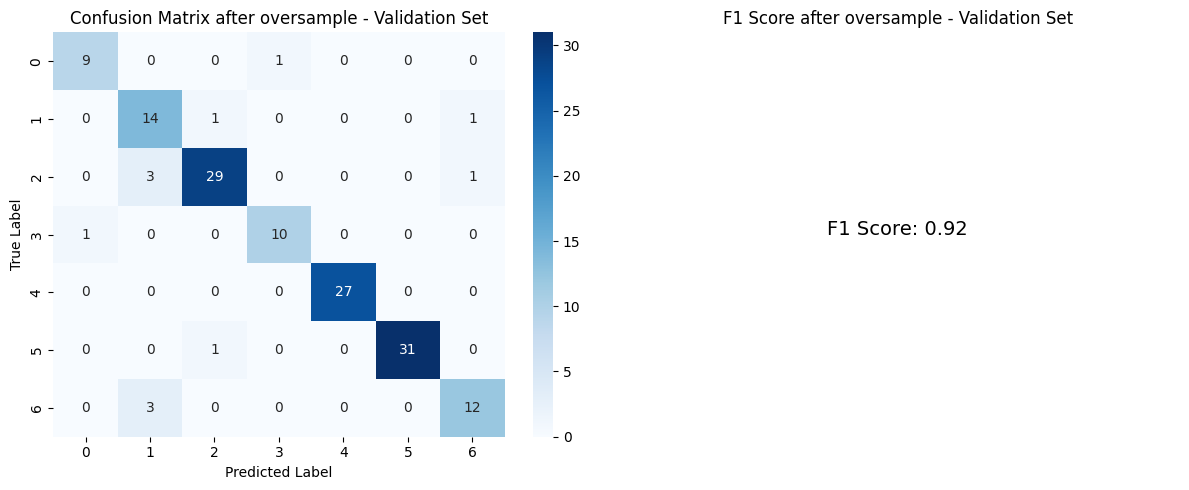

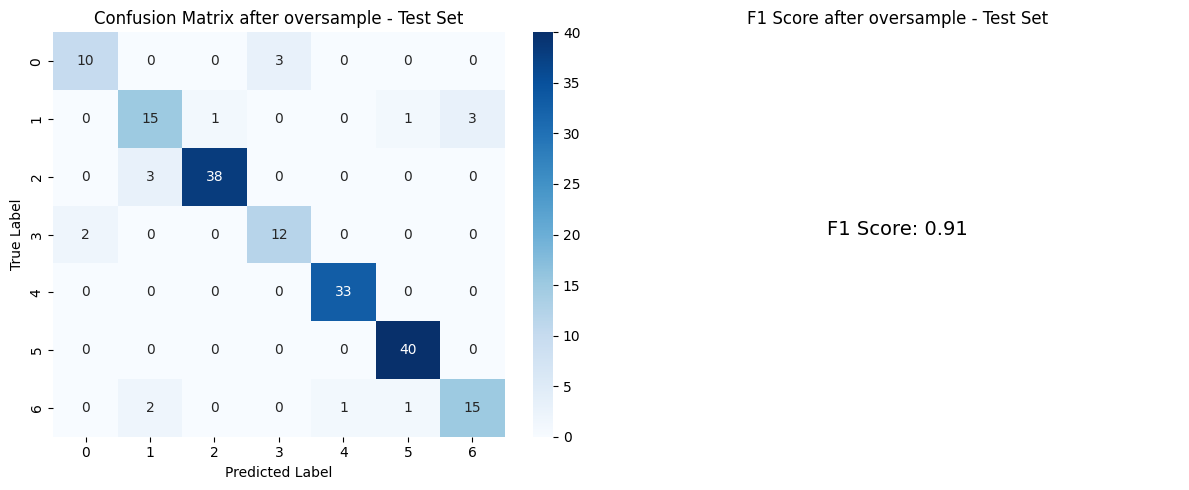

In [15]:
from sklearn.model_selection import cross_val_score

def modelling_RandomForestClassifier_cv(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, cv=5):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    # Initialize Random Forest model
    model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced",
                                    max_features=None, max_samples=0.5, oob_score=True)

    # Perform cross-validation
    cv_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=cv, scoring='f1_micro')

    # Calculate mean and standard deviation of cross-validation scores
    cv_mean_score = cv_scores.mean()
    cv_std_score = cv_scores.std()

    print(f'Cross-validation F1 Score: {cv_mean_score:.2f} +/- {cv_std_score:.2f}')

    # Train the Random Forest model on the entire training data
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix after oversample - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score after oversample - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE and cross-validation:
modelling_RandomForestClassifier_cv(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, cv=5)


Cross Validation F1 Scores: [0.83018868 0.86075949 0.89873418 0.92405063 0.96835443]
Cross-validation F1 Score: 0.90 +/- 0.05


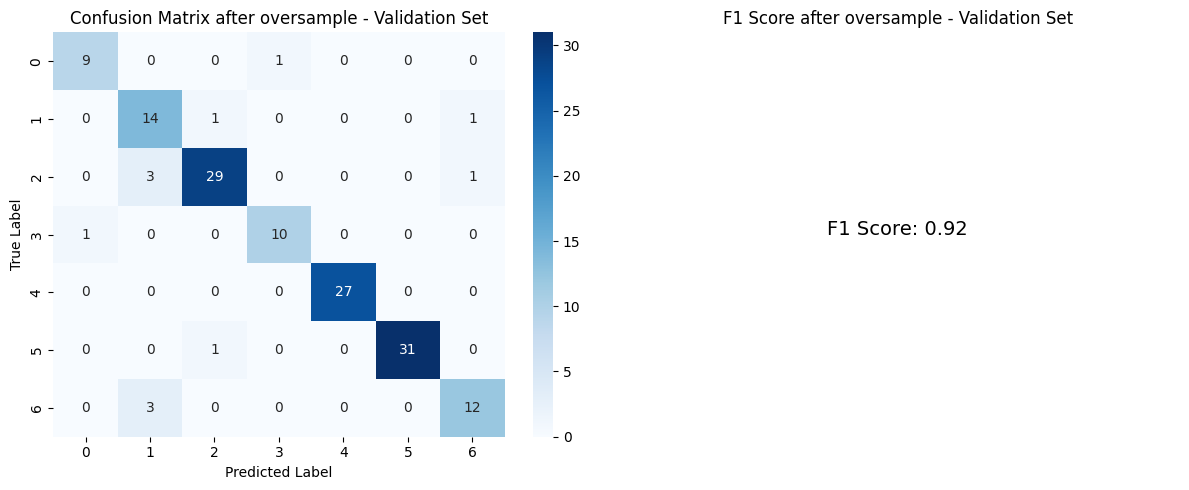

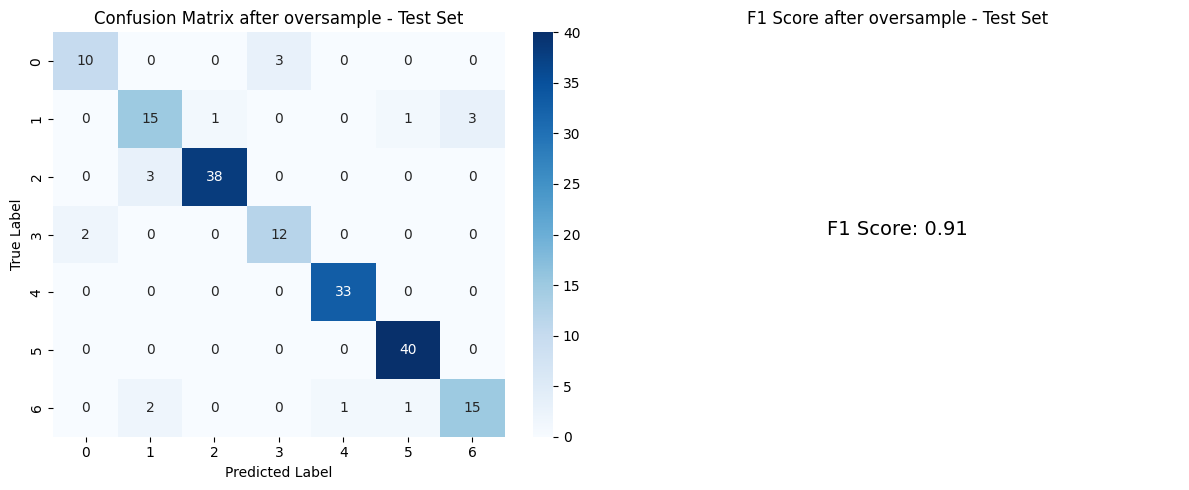

In [16]:
from sklearn.model_selection import cross_val_score

def modelling_RandomForestClassifier_cv(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, cv=5):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    # Initialize Random Forest model
    model = RandomForestClassifier(n_estimators=10, max_depth=12, random_state=0, criterion="entropy", class_weight="balanced",
                                    max_features=None, max_samples=0.5, oob_score=True)

    # Perform cross-validation
    cv_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=cv, scoring='f1_micro')

    # Print cross-validation scores
    print("Cross Validation F1 Scores:", cv_scores)

    # Calculate mean and standard deviation of cross-validation scores
    cv_mean_score = cv_scores.mean()
    cv_std_score = cv_scores.std()

    print(f'Cross-validation F1 Score: {cv_mean_score:.2f} +/- {cv_std_score:.2f}')

    # Train the Random Forest model on the entire training data
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix after oversample - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score after oversample - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE and cross-validation:
modelling_RandomForestClassifier_cv(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, cv=5)
